In [7]:
!ls ../../data

analysis        exploitation    landing         trusted
analysis_output formatted       relations


In [1]:
# --- Imports and Setup ---

import pandas as pd
import torch
from pathlib import Path
import matplotlib.pyplot as plt
import seaborn as sns

# PyKEEN imports
from pykeen.pipeline import pipeline
from pykeen.triples import TriplesFactory
import pykeen.version

# RDFLib for initial graph processing
import rdflib
from rdflib import Graph

print(f"PyKEEN version: {pykeen.version.get_version()}")
print(f"PyTorch version: {torch.__version__}")

# --- Configuration ---
KG_PATH = "../../data/exploitation/knowledge_graph.ttl"
OUTPUT_DIR = Path("../../data/analysis/embeddings")
OUTPUT_DIR.mkdir(parents=True, exist_ok=True)
TRIPLES_PATH = OUTPUT_DIR / "kg_triples_for_pykeen.tsv"

/Users/rogerbaigess/Desktop/IA/3r/BDA/large-scale-data-engineering-ai/.venv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


PyKEEN version: 1.11.1
PyTorch version: 2.7.1


In [2]:
# --- Load and Filter Knowledge Graph for KGE Models ---

print(f"Loading full Knowledge Graph from: {KG_PATH}")
g = Graph()
try:
    g.parse(KG_PATH, format="turtle")
    print(f"Graph loaded successfully with {len(g)} triples.")
except FileNotFoundError:
    print(f"ERROR: Knowledge Graph file not found at {KG_PATH}. Please run the exploitation zone script first.")
    raise

# --- Data Preparation for PyKEEN ---
# KGE models like TransE and DistMult work with entity-relation-entity triples.
# We will filter the graph to keep ONLY these structural triples.
# We are completely ignoring triples with literal objects for this training phase.

print("\nFiltering graph to exclude triples with literal objects...")
entity_triples = []
for s, p, o in g:
    # The condition is simple: the subject (s) and object (o) must be URIs (entities).
    # The predicate (p) is always a URI.
    if isinstance(s, rdflib.URIRef) and isinstance(o, rdflib.URIRef):
        entity_triples.append((str(s), str(p), str(o)))

print(f"Filtered down to {len(entity_triples)} entity-relation-entity triples.")

# Save the filtered triples to a TSV file for PyKEEN
print(f"Saving filtered triples to: {TRIPLES_PATH}")
with open(TRIPLES_PATH, "w") as f:
    # Add a header for clarity, though PyKEEN doesn't strictly need it
    # f.write("head\trelation\ttail\n") 
    for s, p, o in entity_triples:
        f.write(f"{s}\t{p}\t{o}\n")

print("Data preparation for PyKEEN complete.")

Loading full Knowledge Graph from: ../../data/exploitation/knowledge_graph.ttl
Graph loaded successfully with 180513 triples.

Filtering graph to exclude triples with literal objects...
Filtered down to 78126 entity-relation-entity triples.
Saving filtered triples to: ../../data/analysis/embeddings/kg_triples_for_pykeen.tsv
Data preparation for PyKEEN complete.


In [3]:
# --- Create and Split PyKEEN Dataset ---

# Create a TriplesFactory from our TSV file
tf = TriplesFactory.from_path(TRIPLES_PATH, create_inverse_triples=True) # Adding inverse triples can help some models

# Split the data into training, validation, and testing sets
training_set, validation_set, testing_set = tf.split([0.8, 0.1, 0.1], random_state=42)

print("Dataset split successfully:")
print(f"  Training triples:   {training_set.num_triples}")
print(f"  Validation triples: {validation_set.num_triples}")
print(f"  Testing triples:    {testing_set.num_triples}")
print(f"  Total entities:     {tf.num_entities}")
print(f"  Total relations:    {tf.num_relations}")

Dataset split successfully:
  Training triples:   62500
  Validation triples: 7813
  Testing triples:    7813
  Total entities:     29332
  Total relations:    16


In [4]:
# --- Helper Function for Training and Evaluation ---

def run_kge_pipeline(training, validation, testing, model_name, embedding_dim=100, epochs=100):
    """
    Runs the PyKEEN pipeline for a given model and returns the results.
    """
    print(f"\n{'='*20} Starting Pipeline for {model_name} {'='*20}")
    
    result = pipeline(
        training=training,
        validation=validation,
        testing=testing,
        model=model_name,
        model_kwargs=dict(embedding_dim=embedding_dim),
        training_kwargs=dict(
            num_epochs=epochs,
            batch_size=256,
            use_tqdm_batch=False
        ),
        negative_sampler='basic',
        evaluation_kwargs=dict(batch_size=256),
        stopper='early',
        stopper_kwargs=dict(frequency=5, patience=3, metric='hits@10'),
        random_seed=42,
        device='cpu',
    )
    
    print(f"--- Pipeline for {model_name} complete. ---")
    return result

In [5]:
# --- Train and Evaluate Selected Models ---

results = {}

# --- Train TransE ---
transe_result = run_kge_pipeline(
    training=training_set,
    validation=validation_set,
    testing=testing_set,
    model_name='TransE',
    embedding_dim=50, # Can start with smaller embeddings
    epochs=100
)
results['TransE'] = transe_result
transe_result.save_to_directory(OUTPUT_DIR / 'transe_model')


# --- Train DistMult ---
distmult_result = run_kge_pipeline(
    training=training_set,
    validation=validation_set,
    testing=testing_set,
    model_name='DistMult',
    embedding_dim=50,
    epochs=100
)
results['DistMult'] = distmult_result
distmult_result.save_to_directory(OUTPUT_DIR / 'distmult_model')


==================== Starting Pipeline for TransE ====================


INFO:pykeen.triples.triples_factory:Creating inverse triples.
/Users/rogerbaigess/Desktop/IA/3r/BDA/large-scale-data-engineering-ai/.venv/lib/python3.10/site-packages/torch/utils/data/dataloader.py:683: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)
Training epochs on cpu:   4%|▍         | 4/100 [00:17<05:34,  3.49s/epoch, loss=0.256, prev_loss=0.317]WARNING:torch_max_mem.api:Encountered tensors on device_types={'cpu'} while only ['cuda'] are considered safe for automatic memory utilization maximization. This may lead to undocumented crashes (but can be safe, too).
INFO:pykeen.evaluation.evaluator:Evaluation took 50.95s seconds
INFO:pykeen.stoppers.early_stopping:New best result at epoch 5: 0.09720977857417125. Saved model weights to /Users/rogerbaigess/.data/pykeen/checkpoints/best-model-weights-0f1b47bf-79bd-44da-86bd-67f9bcf312bf.pt
INFO:pykeen.training.training_loop:=> Saved checkpoi

--- Pipeline for TransE complete. ---


INFO:pykeen.pipeline.api:Saved to directory: /Users/rogerbaigess/Desktop/IA/3r/BDA/large-scale-data-engineering-ai/data/analysis/embeddings/transe_model
INFO:pykeen.pipeline.api:Using device: cpu
INFO:pykeen.nn.representation:Inferred unique=False for Embedding()
INFO:pykeen.nn.representation:Inferred unique=False for Embedding(
  (regularizer): LpRegularizer()
)
INFO:pykeen.stoppers.early_stopping:Inferred checkpoint path for best model weights: /Users/rogerbaigess/.data/pykeen/checkpoints/best-model-weights-79d53da0-5767-4045-a8a0-f419d4a24b94.pt
INFO:pykeen.triples.triples_factory:Creating inverse triples.
/Users/rogerbaigess/Desktop/IA/3r/BDA/large-scale-data-engineering-ai/.venv/lib/python3.10/site-packages/torch/utils/data/dataloader.py:683: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)



==================== Starting Pipeline for DistMult ====================


Training epochs on cpu:   4%|▍         | 4/100 [00:16<05:14,  3.27s/epoch, loss=1, prev_loss=1]     WARNING:torch_max_mem.api:Encountered tensors on device_types={'cpu'} while only ['cuda'] are considered safe for automatic memory utilization maximization. This may lead to undocumented crashes (but can be safe, too).
INFO:pykeen.evaluation.evaluator:Evaluation took 16.18s seconds
INFO:pykeen.stoppers.early_stopping:New best result at epoch 5: 0.002367848457698707. Saved model weights to /Users/rogerbaigess/.data/pykeen/checkpoints/best-model-weights-79d53da0-5767-4045-a8a0-f419d4a24b94.pt
INFO:pykeen.training.training_loop:=> Saved checkpoint after having finished epoch 5.
Training epochs on cpu:   9%|▉         | 9/100 [00:51<07:42,  5.08s/epoch, loss=0.999, prev_loss=0.999]WARNING:pykeen.utils:Using automatic batch size on device.type='cpu' can cause unexplained out-of-memory crashes. Therefore, we use a conservative small batch_size=32. Performance may be improved by explicitly speci

--- Pipeline for DistMult complete. ---


INFO:pykeen.triples.triples_factory:Stored TriplesFactory(num_entities=29332, num_relations=16, create_inverse_triples=True, num_triples=62500, path="/Users/rogerbaigess/Desktop/IA/3r/BDA/large-scale-data-engineering-ai/data/analysis/embeddings/kg_triples_for_pykeen.tsv") to file:///Users/rogerbaigess/Desktop/IA/3r/BDA/large-scale-data-engineering-ai/data/analysis/embeddings/distmult_model/training_triples
INFO:pykeen.pipeline.api:Saved to directory: /Users/rogerbaigess/Desktop/IA/3r/BDA/large-scale-data-engineering-ai/data/analysis/embeddings/distmult_model


--- Extracting Metrics from Model Results ---
Successfully processed metrics for TransE.
Successfully processed metrics for DistMult.


==================== Final Model Comparison ====================
Metrics evaluated on the testing set (realistic, both sides):
Metric    hits_at_1  hits_at_3  hits_at_5  hits_at_10
Model                                                
DistMult     0.1610     0.2019     0.2363      0.2649
TransE       0.0010     0.0570     0.0737      0.0964

Comparison plot saved to: ../../data/analysis/embeddings/model_comparison.png


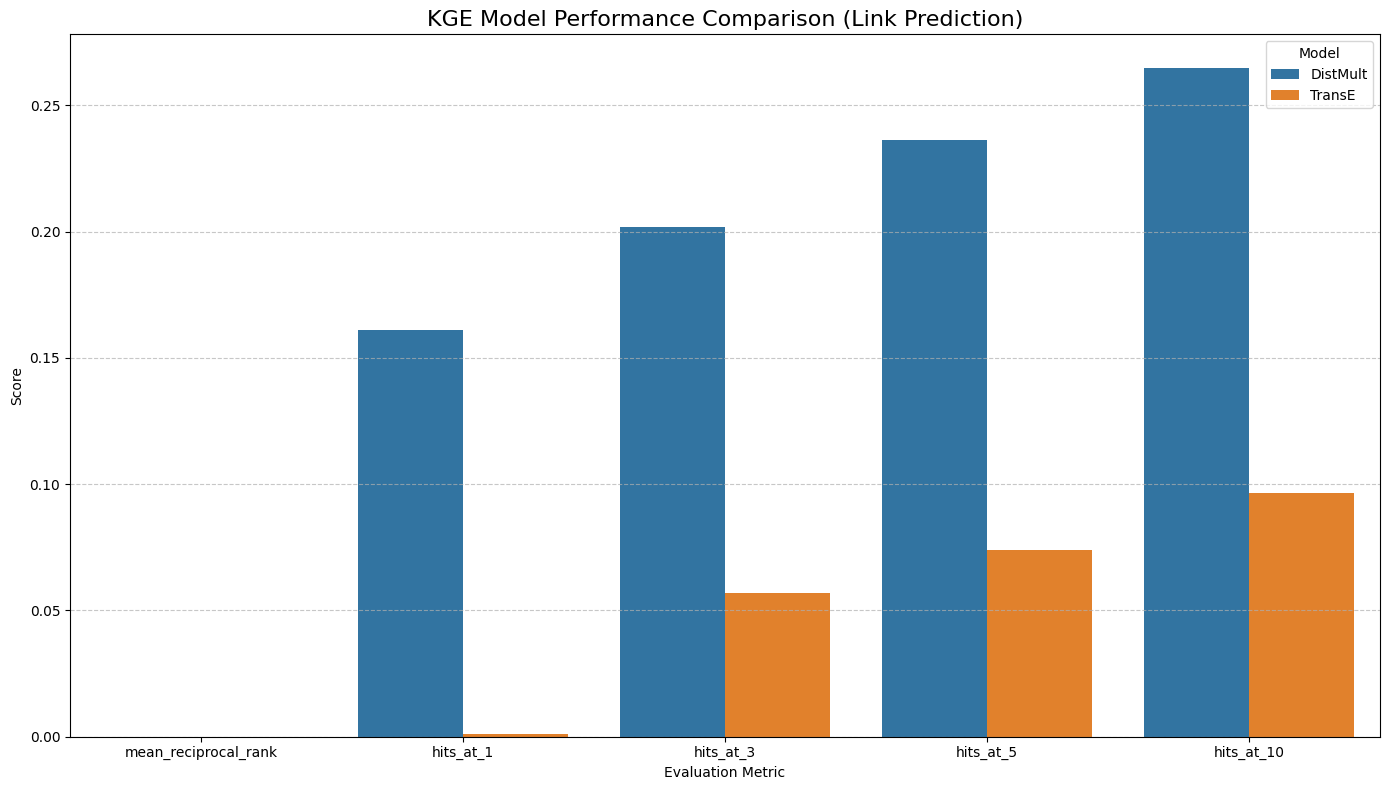

In [ ]:
# --- Compare Model Performance ---

# A list to hold the processed metrics for each model
all_metrics_data = []

# --- Step 1: Extract Metrics by Filtering the DataFrame Correctly ---
print("--- Extracting Metrics from Model Results ---")
for model_name, result in results.items():
    try:
        # Convert the full result to a DataFrame
        metrics_df = result.metric_results.to_df()
        
        # --- Corrected Filtering Logic ---
        # We now use the column names we discovered from the previous debug:
        # 'Side', 'Rank_type', 'Metric', 'Value'
        
        # Filter for the final test set results. Since there is no 'Dataset' column,
        # we assume the results object from the pipeline refers to the 'testing' set evaluation.
        test_metrics = metrics_df[
            (metrics_df['Side'] == 'both') &
            (metrics_df['Rank_type'] == 'realistic')
        ].copy()
        
        # Add the model name for grouping later
        test_metrics['Model'] = model_name
        
        all_metrics_data.append(test_metrics)
        print(f"Successfully processed metrics for {model_name}.")
        
    except KeyError as e:
        # This is a safety net in case the columns change again
        print(f"\n!!! ERROR processing metrics for {model_name}. A required column is missing: {e}")
        print("Available columns were:", list(metrics_df.columns))
        continue
    except Exception as e:
        print(f"\n!!! An unexpected error occurred while processing metrics for {model_name}: {e}")
        continue

# --- Step 2: Consolidate and Plot ---
if all_metrics_data:
    # Concatenate all results into a single DataFrame
    results_df = pd.concat(all_metrics_data, ignore_index=True)
    
    # Select and reorder columns for display
    display_cols = ['Model', 'Metric', 'Value']
    results_df_display = results_df[display_cols]
    
    # Pivot the table for better comparison
    pivot_df = results_df_display.pivot_table(
        index='Model', 
        columns='Metric', 
        values='Value',
        aggfunc='first'
    )
    
    # Define the metrics we want to see in the final table and plot
    final_metrics_order = [
        'mean_reciprocal_rank', 
        'hits_at_1', 
        'hits_at_3', 
        'hits_at_5', 
        'hits_at_10'
    ]
    # Filter for only those metrics that actually exist in our results
    final_metrics_existing = [m for m in final_metrics_order if m in pivot_df.columns]
    
    print("\n\n" + "="*20 + " Final Model Comparison " + "="*20)
    print("Metrics evaluated on the testing set (realistic, both sides):")
    
    # Format the output for readability
    print(pivot_df[final_metrics_existing].to_string(float_format="%.4f"))

    # --- Plotting the results ---
    plot_df = pivot_df[final_metrics_existing].reset_index()
    melted_df = plot_df.melt(id_vars='Model', var_name='Metric', value_name='Score')
    
    plt.figure(figsize=(14, 8))
    sns.barplot(x='Metric', y='Score', hue='Model', data=melted_df, order=final_metrics_order)
    plt.title('KGE Model Performance Comparison (Link Prediction)', fontsize=16)
    plt.ylabel('Score')
    plt.xlabel('Evaluation Metric')
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.tight_layout()
    plot_path = OUTPUT_DIR / 'model_comparison.png'
    plt.savefig(plot_path)
    print(f"\nComparison plot saved to: {plot_path}")
    plt.show()

else:
    print("No model results to display. Check for errors during metric processing.")